# Tutorial de Pytorch 6: Transfer Learning

El "transfer learning" (aprendizaje por transferencia) es una técnica en el campo del aprendizaje automático y la inteligencia artificial donde un modelo desarrollado para una tarea se reutiliza como punto de partida para un modelo en una segunda tarea. Es una estrategia popular en el aprendizaje profundo debido a que puede entrenar modelos de aprendizaje profundo con relativamente pocos datos. Esto es especialmente útil en casos donde la recopilación de un conjunto de datos grande y completo es difícil o costosa.

Hay dos enfoques principales en el transfer learning:

**Fine-Tuning (Ajuste Fino):** En este enfoque, se toma un modelo preentrenado (generalmente entrenado en un conjunto de datos grande y diverso, como ImageNet) y se ajusta ligeramente para adaptarlo a una tarea específica. Esto se hace entrenando el modelo en el nuevo conjunto de datos, pero con un ritmo de aprendizaje muy bajo, lo que permite que el modelo ajuste sus pesos finales para la nueva tarea sin olvidar lo que ya ha aprendido. A menudo, solo se reentrenan las últimas capas del modelo, mientras que las primeras capas (que suelen capturar características generales de las imágenes) se mantienen intactas.

**Feature Extraction (Extracción de Características):** En este método, se utiliza un modelo preentrenado como un extractor de características fijas. Se pasan los datos a través del modelo y se extraen las características de una de las capas intermedias. Estas características se utilizan luego para entrenar un nuevo clasificador para la nueva tarea. En este caso, los pesos del modelo preentrenado no se modifican durante el entrenamiento del nuevo clasificador.

In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt

# Cargar el modelo VGG16 preentrenado
vgg16 = models.vgg16(pretrained=True)

/Users/cayetano/Propio/Notebooks/Machine Learning/RL/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cayetano/Propio/Notebooks/Machine Learning/RL/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Hemos cargado el modelo VGG16. Vamos a ver sus capas de clasificación (las últimas capas).

In [2]:
print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


Veamos ahora las capas de extracción de características (las primeras capas).

In [3]:
print(vgg16.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

<img src="imgs/VGG16_ilu.png">

In [4]:
vgg16.eval()  # Poner el modelo en modo de evaluación

# Función para cargar y preprocesar la imagen
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Añadir una dimensión de lote
    return image

# Cargar y preprocesar la imagen
image_path = 'imgs/trilobite.jpeg'  # Reemplazar con la ruta de tu imagen
image = preprocess_image(image_path)

# Clasificar la imagen
with torch.no_grad():
    outputs = vgg16(image)
    _, predicted = outputs.max(1)

# Obtener la etiqueta de la clase predicha (necesitarás un mapeo de índices a etiquetas de ImageNet)
print(f"Clase predicha: {predicted.item()}")


Clase predicha: 69


### Preparación de los datos

In [5]:
# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
# Cargando el conjunto de datos
dataset = datasets.ImageFolder('data/Sign-Language', transform=transform)

In [7]:
# Separando los datos en entrenamiento y prueba
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [8]:
# Cargadores de datos
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Configuración del dispositivo (usa GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Modelo

In [10]:
for layer in vgg16.features:
    layer.requires_grad = False

# Definiendo la red neuronal
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(25088, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 25088)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
class MyVGG16(nn.Module):
    def __init__(self):
        super(MyVGG16, self).__init__()
        self.features = vgg16.features
        self.classifier = Classifier()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    
# Creamos la red neuronal
model = MyVGG16().to(device)

### Optimizador y Función de Pérdida

In [11]:
# Definiendo la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Entrenamiento

In [12]:
model.train()  # modelo en modo de entrenamiento

# Entrenamiento
num_epochs = 3
history = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 1):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 0:
            print(f'Epoch {epoch+1}, Batch {i}, Loss: {running_loss/10:.4f}')
            history.append(running_loss/10)
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 10, Loss: 4150458.5567
Epoch 1, Batch 20, Loss: 12740.8787
Epoch 1, Batch 30, Loss: 16780.9338
Epoch 1, Batch 40, Loss: 2.3126
Epoch 1, Batch 50, Loss: 2.3023
Epoch 2, Batch 10, Loss: 2.3079
Epoch 2, Batch 20, Loss: 2.3119
Epoch 2, Batch 30, Loss: 2.3018
Epoch 2, Batch 40, Loss: 2.3047
Epoch 2, Batch 50, Loss: 2.3018
Epoch 3, Batch 10, Loss: 2.3001
Epoch 3, Batch 20, Loss: 2.3021
Epoch 3, Batch 30, Loss: 2.3026
Epoch 3, Batch 40, Loss: 2.3044
Epoch 3, Batch 50, Loss: 2.3110
Finished Training


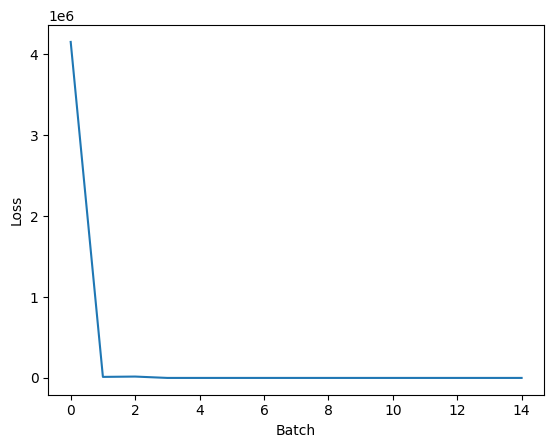

In [13]:
# Plot loss
plt.plot(history)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

In [14]:
# Evaluación
correct = 0
total = 0
model.eval()  # Poner el modelo en modo de evaluación
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test images: {100 * correct / total:.2f}%')

Accuracy on test images: 7.99%
